## Load and Merge

In [2]:
data_folder = os.getcwd() + "/data/tourism"
samoa_folder = data_folder + "/samoa/"

In [3]:
samoa = (pd.read_csv(samoa_folder + "intermediate/samoa_byCon.csv")
           .drop("Unnamed: 0", axis=1))

samoa["Date"] = pd.to_datetime(samoa["Date"])
samoa["Date"] = samoa["Date"] - timedelta(days=7)

samoa[["Year", "Month"]].groupby("Year").count()
samoa.head(5)

,Date,Total arrivals (persons),American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0


In [4]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))
si_mean = covid_si.groupby("date").mean().reset_index()
si_mean["date"] = pd.to_datetime(si_mean["date"])

In [5]:
si_mean["year"], si_mean["month"] = si_mean["date"].dt.year, si_mean["date"].dt.month
si_mean = si_mean.groupby(["year", "month"]).mean().reset_index()
si_mean["date"] = [str(year) + "-" + str(month) for year, month in zip(si_mean.year, si_mean.month)]
si_mean["date"] = pd.to_datetime(si_mean["date"])
si_mean.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [6]:
samoa = (samoa.merge(si_mean, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"Total arrivals (persons)": "Total",
                  "stringency_index": "covid"}, axis=1))
samoa.columns = [col.lower() for col in samoa.columns]
samoa.head(5)

,date,total,american samoa,australia,europe,new zealand,usa,other countries,cruise ships,year,month,year,month,covid
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.0,0.0,0.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.0,0.0,0.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.0,0.0,0.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.0,0.0,0.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.0,0.0,0.0


In [7]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_samoa.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
samoa = (samoa.merge(gt[["date", "samoa travel"]], how="left", on="date")
      .rename({"samoa travel": "samoa_travel"}, axis=1)
      .fillna(0))
samoa.head(5)

,date,total,american samoa,australia,europe,new zealand,usa,other countries,cruise ships,year,month,year,month,covid,samoa_travel
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.0,0.0,0.0,0.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.0,0.0,0.0,0.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.0,0.0,0.0,0.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.0,0.0,0.0,0.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.0,0.0,0.0,0.0


In [8]:
get_adf_df(samoa, ["total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-3.403589,0.010837,14.0,227.0,-3.45949,-2.874358,-2.573602


## SARIMAX

In [9]:
naive_pred = naive_method(samoa["total"])
mean_pred = mean_method(samoa["total"])
snaive_pred = seasonal_naive_method(samoa["total"])

benchmark = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(samoa["total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,MAPE
naive,1.180276e+07,3435.514859,2313.560166,inf
mean,2.193805e+07,4683.807205,3367.534731,inf
seasonal naive,1.643507e+07,4054.018920,2003.082645,inf


training size : 229, testing size : 13
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4245.733, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4372.304, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4089.331, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4191.195, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4370.307, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4351.186, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4076.820, Time=0.59 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4069.426, Time=0.83 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4067.892, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4222.815, Time=0.20 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4121.591, Time=0.76 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4158.755, Time=0.78 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=4152.103, Time=1.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4094

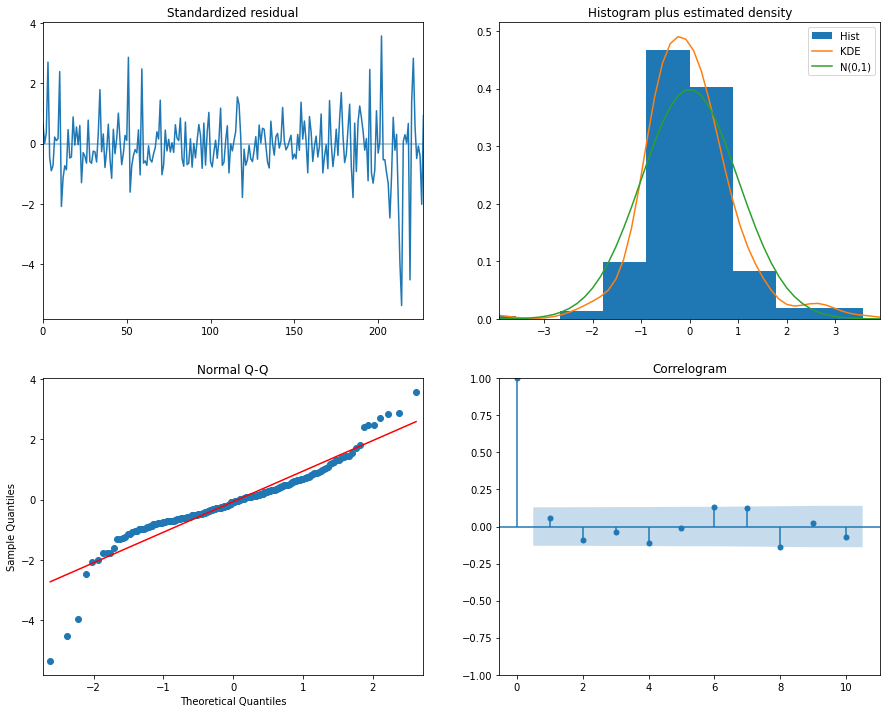

In [10]:
so = SARIMAXPipeline(data=samoa, y_var="total",
                     exog_var=["covid", "samoa_travel"], transform_method=None, training_ratio=0.95)
so.transform()
so_sw = so.stepwise_search()

In [11]:
# Set parameter range
p, d, q = range(0, 3), [0], range(0, 3)
P, D, Q, s = range(0, 3), [0], range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
so.manual_search(all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:5739.32
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:4671.73
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:4521.71
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:4176.81
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:4496.46
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:4709.81
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:4500.97
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:4627.69
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:4686.64
Tried out SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:4672.2
Tried out SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:4673.23
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:4654.19
Tried out SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:4142.08
Tried out SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:4629.9
Tried out SARIMAX(0, 0, 1)x(1, 0, 2, 12) - AIC:4551.04
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:4193.41
Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:4630.24
Tried out SARIMAX(0, 0, 1)x(2, 0, 2, 12) - AIC:4633.87
Tried out SA

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157d1dac0>,
  5739.322179246121,
  ((0, 0, 0), (0, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1579ac520>,
  4671.727239318164,
  ((0, 0, 0), (0, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1579e4640>,
  4521.706389100846,
  ((0, 0, 0), (0, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1579e4490>,
  4176.806570797204,
  ((0, 0, 0), (1, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157953a60>,
  4496.462092007589,
  ((0, 0, 0), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157a9cc40>,
  4709.809780183936,
  ((0, 0, 0), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157a9bbb0>,
  4500.967884206227,
  ((0, 0, 0), (2, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157c3edf0>,
  4627.687709925591,

In [12]:
so_msres = so.manual_search_results
so_msres.sort(key=lambda x: x[1])

In [13]:
so_models = []
so_models.append(pm.ARIMA(
    so_sw["order"], so_sw["seasonal_order"],  exog=so.exog[:so.training_size]))

for res in so_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=so.exog[:so.training_size])
    so_models.append(model)
    
so_comp = so.compare_models(
    so.transformed_y[:so.training_size], so.exog[:so.training_size], so_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] f

In [14]:
so_comp

{'model': [ARIMA(order=(0, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(2, 0, 0), seasonal_order=(2, 0, 0, 12)),
  ARIMA(order=(1, 0, 0), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 0, 0), seasonal_order=(2, 0, 0, 12)),
  ARIMA(order=(0, 0, 1), seasonal_order=(1, 0, 0, 12)),
  ARIMA(order=(2, 0, 0), seasonal_order=(1, 0, 0, 12))],
 'cv_scores': [array([ 25.68976209,  64.01696036,  39.714329  ,  52.71958935,
          26.1205062 ,  45.07525481,  23.50906654,  52.638865  ,
          36.2026898 ,  42.29774584,  18.6357097 ,  47.46260176,
          33.25463922,  71.51960316,  21.5751169 , 200.        ,
          71.16960126,  53.92922376,  31.83171085,  46.1903749 ,
          29.29608056,  46.00940781,  33.07709683,  31.39615885,
          53.94172882,  59.27832734,  59.21658211,  44.64551543,
          29.83122761,  57.46035063,  40.82633513, 200.        ,
          96.54600741, 197.02539293, 200.        ]),
  array([ 14.82782971,  43.54655719,  14.6368429 ,  17.67326709,
   

In [15]:
best_original = so_msres[4][0]
original_mod = so.get_prediction_df(best_original, steps=so.test_size, exog=so.exog[-so.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([samoa[["date", "total"]], original_mod], axis=1)
original_mod.head(5)

,date,total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2002-08-01,8260.0,0.000000,9527.545216,-18673.645485,18673.645485,NaN
1,2002-09-01,6708.0,6417.700079,5998.050839,-5338.263543,18173.663702,NaN
2,2002-10-01,5737.0,7097.245348,4713.003364,-2140.071503,16334.562200,NaN
3,2002-11-01,6653.0,6011.555544,4704.650406,-3209.389812,15232.500900,NaN
4,2002-12-01,13042.0,5789.810121,4689.248044,-3400.947160,14980.567402,NaN


In [18]:
org_pred = original_mod["train_pred"].fillna(0) + original_mod["test_pred"].fillna(0)
org_eval = pd.DataFrame(calculate_evaluation(samoa["total"], org_pred), index=["original"])
model_eval = pd.concat([benchmark, org_eval])
model_eval

,MSE,RMSE,MAE,MAPE
naive,1.180276e+07,3435.514859,2313.560166,inf
mean,2.193805e+07,4683.807205,3367.534731,inf
seasonal naive,1.643507e+07,4054.018920,2003.082645,inf
original,4.229098e+06,2056.476983,1429.586539,inf


### Scaled Logit

training size : 229, testing size : 13
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=708.514, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=716.059, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=675.134, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=655.690, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=714.096, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=657.804, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=650.523, Time=0.40 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=630.359, Time=0.81 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=629.445, Time=0.96 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=649.272, Time=0.49 sec
 ARIMA(1,1

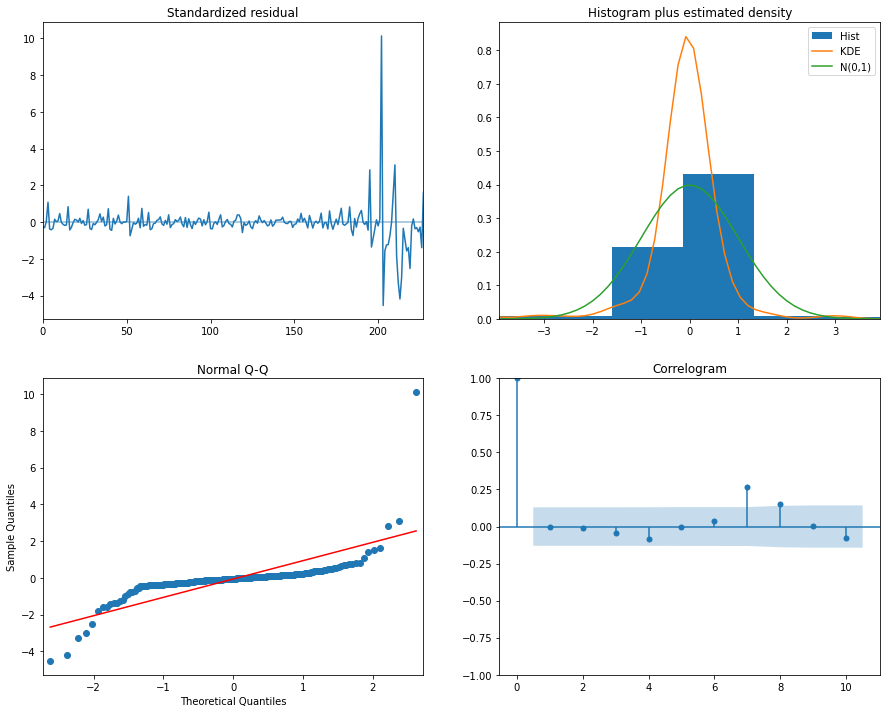

In [20]:
ss = SARIMAXPipeline(data=samoa, y_var="total",
                     exog_var=["covid"], transform_method="scaledlogit", training_ratio=0.95)
ss.transform()
ss_sw = ss.stepwise_search()

In [21]:
ss.manual_search(all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:731.22
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:730.57
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:730.68
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:730.08
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:721.34
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:721.67
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:729.1
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:722.18
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:725.27
Tried out SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:681.23
Tried out SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:679.13
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:678.71
Tried out SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:678.24
Tried out SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:664.36
Tried out SARIMAX(0, 0, 1)x(1, 0, 2, 12) - AIC:665.13
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:676.55
Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:665.51
Tried out SARIMAX(0, 0, 1)x(2, 0, 2, 12) - AIC:668.35
Tried out SARIMAX(0, 0, 2)x(0

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177db6b20>,
  731.2201388160215,
  ((0, 0, 0), (0, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177d6e580>,
  730.5704391425479,
  ((0, 0, 0), (0, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177d88760>,
  730.6844347713552,
  ((0, 0, 0), (0, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177dd74f0>,
  730.0780983692034,
  ((0, 0, 0), (1, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177d888e0>,
  721.3370913706706,
  ((0, 0, 0), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177e94820>,
  721.6662608568292,
  ((0, 0, 0), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177e912b0>,
  729.0993777321128,
  ((0, 0, 0), (2, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177e9d4f0>,
  722.1762791328545,

In [22]:
ss_msres = ss.manual_search_results
ss_msres.sort(key=lambda x: x[1])
ss_msres

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157a18850>,
  630.0024399027791,
  ((2, 0, 1), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2f00d0a90>,
  630.0234049051787,
  ((1, 0, 2), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2ad7d7190>,
  630.7405503504543,
  ((1, 0, 1), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x177ef30d0>,
  631.1853361838466,
  ((2, 0, 1), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2f0108d60>,
  631.1903968431362,
  ((1, 0, 2), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157a87bb0>,
  631.2961189137859,
  ((2, 0, 1), (2, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2f0141f10>,
  631.3556310889758,
  ((1, 0, 2), (2, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2f000e1f0>,
  632.0078507947798,

In [23]:
ss_models = []
ss_models.append(pm.ARIMA(
    ss_sw["order"], ss_sw["seasonal_order"],  exog=ss.exog[:ss.training_size]))

for res in ss_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=ss.exog[:ss.training_size])
    ss_models.append(model)
    
ss_comp = ss.compare_models(
    ss.transformed_y[:ss.training_size], ss.exog[:ss.training_size], ss_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] f

In [25]:
ss_comp

{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 2, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(1, 0, 2, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(1, 0, 2, 12))],
 'cv_scores': [array([ 28.77291732, 116.08209011,  73.24025817, 127.72276733,
          27.01943701, 180.60948798,  55.88998098, 191.2772775 ,
          96.96922387, 177.47768209,  79.10315718, 200.        ,
         165.27963209, 200.        ,  49.34967227, 186.76812374,
          77.74948048, 190.31469427, 178.32672081, 174.03948547,
          63.34401796, 161.25579518,  66.45662937, 170.7712986 ,
          47.56225951, 174.06917108, 123.64965013, 167.47934793,
         127.77855085, 143.32368521,  92.42641086, 145.97530549,
         191.99493316,  49.61294704,  23.63953787]),
  array([ 28.42070495,  27.19294762,  37.45556204,  36.61672885,
   

In [27]:
best_ss = ss_msres[3][0]
# best_ss.save(samoa_folder + "/model/best_scaled.pkl")
best_ss_mod = ss.get_prediction_df(
    best_ss, 13, ss.exog[-ss.test_size:])
lower = samoa["total"].min() - 1
upper = samoa["total"].max() + 1

for col_idx, col in enumerate(best_ss_mod.columns):
    for row_idx, _ in enumerate(best_ss_mod[col]):
        best_ss_mod.iloc[row_idx, col_idx] = ss.inverse_scaledlogit(
            best_ss_mod.iloc[row_idx, col_idx], upper, lower)
        
best_ss_mod = pd.concat([samoa[["date", "total"]], best_ss_mod], axis=1)
best_ss_mod.head(20)

,date,total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2002-08-01,8260.0,12323.500000,20920.705589,809.706228,23837.293772,NaN
1,2002-09-01,6708.0,9091.453393,18356.772355,1647.029650,20374.437765,NaN
2,2002-10-01,5737.0,7921.576415,18158.549618,1460.551034,19241.698161,NaN
3,2002-11-01,6653.0,7065.806552,18075.740229,1291.242300,18359.839329,NaN
4,2002-12-01,13042.0,7259.484594,18036.532901,1359.021647,18463.263885,NaN
5,2003-01-01,7555.0,10190.672734,18016.185669,2227.774172,20539.193418,NaN
6,2003-02-01,5968.0,8409.963452,18004.642088,1684.196551,19354.081201,NaN
7,2003-03-01,5550.0,7423.320743,17997.425259,1421.490749,18536.947759,NaN
8,2003-04-01,7283.0,6880.808953,17992.398571,1287.281696,18022.751690,NaN
9,2003-05-01,7190.0,7476.884692,17988.411473,1440.291195,18567.537157,NaN


In [29]:
pred_series = best_ss_mod["train_pred"].fillna(0) + best_ss_mod["test_pred"].fillna(0)
ss_eval = pd.DataFrame(calculate_evaluation(samoa["total"], pred_series), index=["scaled logit"])
ss_eval

,MSE,RMSE,MAE,MAPE
scaled logit,3.918651e+06,1979.558366,1273.142006,inf


Text(0.5, 1.0, "Samoa's Visitor Arrivals")

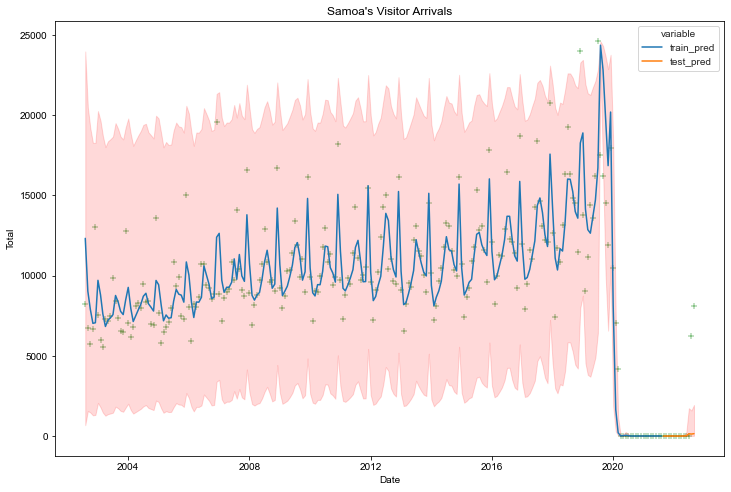

In [19]:
ss_viz_df = best_ss_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
ss_viz_df["Date"] = pd.to_datetime(ss_viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
sns.set_style("whitegrid")
sns.scatterplot(x="Date", y="Total", data=best_ss_mod, color="green", marker="+")
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.15, color="red", data=best_ss_mod)
sns.lineplot(data=ss_viz_df, x="Date", y="value", hue="variable")
plt.title("Samoa's Visitor Arrivals")

## VARMAX

In [45]:
samoa_merged = (pd.read_csv(samoa_folder + "intermediate/samoa_merged.csv")
                .drop("Unnamed: 0", axis=1))

samoa_merged["date"] = [str(y) + "-" + str(m)
                        for y, m in zip(samoa_merged.Year, samoa_merged.Month)]
samoa_merged["date"] = pd.to_datetime(samoa_merged["date"])
samoa_merged = (samoa_merged.merge(si_mean, how="left", on="date")
                            .drop(["year", "month"], axis=1))
samoa_merged.columns = [col.lower() for col in samoa_merged.columns]
samoa_merged.head(5)

,year,month,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,total arrivals (persons),american samoa,australia,europe,new zealand,usa,other countries,cruise ships,date,stringency_index
0,2019,1,90.0,93.0,26332.0,26389.0,13755.0,1116.0,3434.0,612.0,6290.0,862.0,1441.0,500.0,2019-01-01,NaN
1,2019,2,71.0,84.0,17320.0,17681.0,9044.0,968.0,1820.0,458.0,3645.0,594.0,1559.0,2180.0,2019-02-01,NaN
2,2019,3,85.0,109.0,20843.0,21546.0,11163.0,1089.0,2481.0,716.0,4400.0,981.0,1496.0,6730.0,2019-03-01,NaN
3,2019,4,84.0,117.0,20801.0,21751.0,14413.0,1204.0,3122.0,658.0,6887.0,827.0,1715.0,2519.0,2019-04-01,NaN
4,2019,5,85.0,115.0,20843.0,21679.0,13565.0,1215.0,3143.0,492.0,5742.0,962.0,2011.0,0.0,2019-05-01,NaN


In [47]:
samoa_merged = (samoa_merged.merge(gt[["date", "samoa travel"]], how="left", on="date")
                .rename({"total arrivals (persons)": "total"}, axis=1))
samoa_merged.head(5)

,year,month,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,total,american samoa,australia,europe,new zealand,usa,other countries,cruise ships,date,stringency_index,samoa travel_x,samoa travel_y
0,2019,1,90.0,93.0,26332.0,26389.0,13755.0,1116.0,3434.0,612.0,6290.0,862.0,1441.0,500.0,2019-01-01,NaN,0.978500,0.978500
1,2019,2,71.0,84.0,17320.0,17681.0,9044.0,968.0,1820.0,458.0,3645.0,594.0,1559.0,2180.0,2019-02-01,NaN,0.713992,0.713992
2,2019,3,85.0,109.0,20843.0,21546.0,11163.0,1089.0,2481.0,716.0,4400.0,981.0,1496.0,6730.0,2019-03-01,NaN,0.648102,0.648102
3,2019,4,84.0,117.0,20801.0,21751.0,14413.0,1204.0,3122.0,658.0,6887.0,827.0,1715.0,2519.0,2019-04-01,NaN,0.668381,0.668381
4,2019,5,85.0,115.0,20843.0,21679.0,13565.0,1215.0,3143.0,492.0,5742.0,962.0,2011.0,0.0,2019-05-01,NaN,0.979695,0.979695


In [48]:
scaled_logit = SARIMAXPipeline.scaledlogit_transform
inverse_transform = SARIMAXPipeline.inverse_scaledlogit

In [49]:
varma_cols = ["total", "seats_arrivals_intl", "samoa_travel"]
for col in varma_cols[:2]:
    samoa_merged["sl_"+str(col)] = scaled_logit(samoa_merged[col])

In [54]:
display(get_adf_df(samoa_merged, ["sl_total", "seats_arrivals_intl"]))

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
sl_total,-1.777932,0.391472,0.0,44.0,-3.588573,-2.929886,-2.603185
seats_arrivals_intl,-2.619750,0.088984,9.0,35.0,-3.632743,-2.948510,-2.613017


## Ratio Approch

In [56]:
samoa_merged["ratio"] = (samoa_merged["total"])/(samoa_merged["seats_arrivals_intl"])
samoa_merged = samoa_merged.merge(gt[["samoa flights", "samoa travel", "date"]], how="left", on="date")
samoa_merged.head(5)

,year,month,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,total,american samoa,australia,europe,...,cruise ships,date,stringency_index,samoa travel_x,samoa travel_y,sl_total,sl_seats_arrivals_intl,ratio,samoa flights,samoa travel
0,2019,1,90.0,93.0,26332.0,26389.0,13755.0,1116.0,3434.0,612.0,...,500.0,2019-01-01,NaN,0.978500,0.978500,0.233355,2.189243,0.522368,2.710557,0.978500
1,2019,2,71.0,84.0,17320.0,17681.0,9044.0,968.0,1820.0,458.0,...,2180.0,2019-02-01,NaN,0.713992,0.713992,-0.545315,0.351721,0.522171,2.282447,0.713992
2,2019,3,85.0,109.0,20843.0,21546.0,11163.0,1089.0,2481.0,716.0,...,6730.0,2019-03-01,NaN,0.648102,0.648102,-0.188884,0.891010,0.535575,1.909826,0.648102
3,2019,4,84.0,117.0,20801.0,21751.0,14413.0,1204.0,3122.0,658.0,...,2519.0,2019-04-01,NaN,0.668381,0.668381,0.342387,0.883965,0.692899,2.071637,0.668381
4,2019,5,85.0,115.0,20843.0,21679.0,13565.0,1215.0,3143.0,492.0,...,0.0,2019-05-01,NaN,0.979695,0.979695,0.202154,0.891010,0.650818,1.872448,0.979695


In [57]:
temp = (samoa_merged[["ratio", "stringency_index", "date", "samoa flights", "samoa travel"]]
        .reset_index()
        .drop("index", axis=1)
        .rename({"samoa flights": "samoa_flights",
                 "samoa travel": "samoa_travel"}, axis=1)
        .fillna(0))
temp["covid"] = (temp.date >= "2020-03-12")
temp["quarter"] = temp["date"].dt.quarter
temp.head(5)

,ratio,stringency_index,date,samoa_flights,samoa_travel,covid,quarter
0,0.522368,0.0,2019-01-01,2.710557,0.978500,False,1
1,0.522171,0.0,2019-02-01,2.282447,0.713992,False,1
2,0.535575,0.0,2019-03-01,1.909826,0.648102,False,1
3,0.692899,0.0,2019-04-01,2.071637,0.668381,False,2
4,0.650818,0.0,2019-05-01,1.872448,0.979695,False,2


In [58]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="ratio ~ covid * stringency_index + C(quarter) + samoa_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.850
Model:                            WLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     29.93
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           2.19e-13
Time:                        14:44:02   Log-Likelihood:                 30.672
No. Observations:                  45   AIC:                            -45.34
Df Residuals:                      37   BIC:                            -30.89
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3445      0.133      2.597      0.013       0.076       0.613
covid[T.True]                     -0.3052      0.116     -2.640      0.012      -0.539      -0.071
C(quarter)[T.2]                    0.0400      0.062      0.646      0.522      -0.086       0.166
C(quarter)[T.3]                    0.1385      0.062      2.221      0.033       0.012       0.265
C(quarter)[T.4]                    0.0512      0.062      0.822      0.416      -0.075       0.177
stringency_index                  -0.0100      0.004     -2.260      0.030      -0.019      -0.001
covid[T.True]:stringency_index     0.0047      0.006      0.828      0.413      -0.007       0.016
samoa_travel                       0.2829      0.151      1.878      0.068      -0.022       0.588
==============================================================================
Omnibus:                       17.060   Durbin-Watson:                   0.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.071
Skew:                           1.093   Prob(JB):                     1.32e-06
Kurtosis:                       6.108   Cond. No.                         562.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

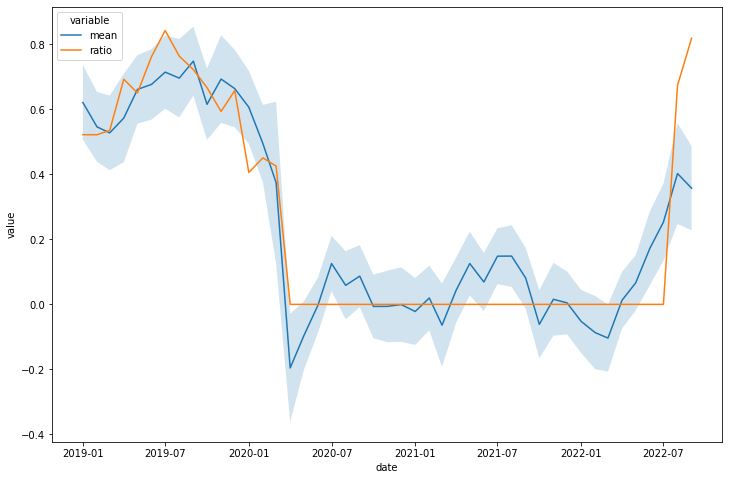

In [59]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)

ratio_viz_df = ratio_stats[["mean", "ratio", "date"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=ratio_stats, x="date", y1="mean_ci_lower",
                y2="mean_ci_upper", alpha=0.2)
plt.show()

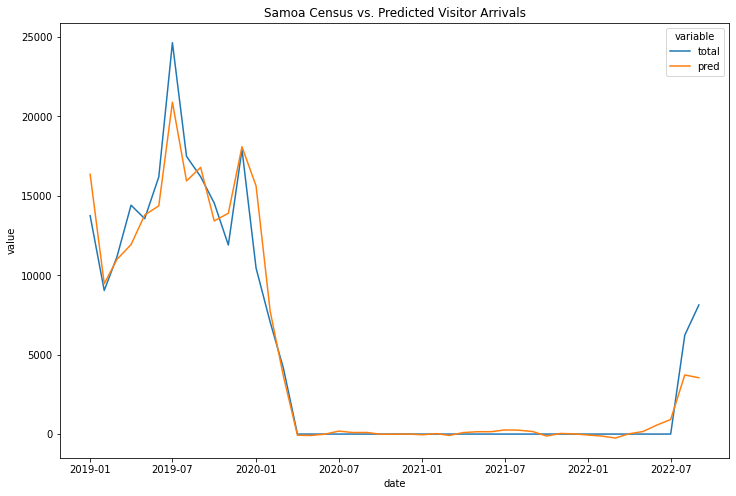

In [62]:
samoa_merged["pred"] = ratio_stats["mean"] * samoa_merged["seats_arrivals_intl"]

pred_viz_df = samoa_merged[["date", "total", "pred"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=pred_viz_df, x="date", y="value", hue="variable")
plt.title("Samoa Census vs. Predicted Visitor Arrivals")
plt.show()

In [67]:
naive_pred = naive_method(samoa_merged["total"])
mean_pred = mean_method(samoa_merged["total"])

benchmark_var = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred]):
    metrics = calculate_evaluation(samoa_merged["total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark_var = pd.concat([benchmark_var, metrics_df], axis=0)

benchmark_var.index = ["naive", "mean"]
benchmark_var

,MSE,RMSE,MAE,MAPE
naive,7.970104e+06,2823.137282,1518.795455,inf
mean,4.747392e+07,6890.131975,6027.062716,inf


In [63]:
ratio_eval = pd.DataFrame(calculate_evaluation(samoa_merged["total"], samoa_merged["pred"]), index=["ratio"])

,MSE,RMSE,MAE,MAPE
ratio,2.107651e+06,1451.775046,763.990597,inf
